# Simple straight line lane mark detection
Using the opencv techniques , lets start to detect the straight lane lines of the road image

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Read in the image
image = mpimg.imread('CarND-LaneLines-P1-master/test_images/solidYellowLeft.jpg')
image.shape

(540, 960, 3)

In [22]:
# Grab the x and y size and make a copy of the image
imgHeight = image.shape[0]
imgWidth = image.shape[1]

In [23]:
# Display the image
def plot_image(image, title = "Image"):
    plt.imshow(image)
    plt.title(title)
    plt.show()

# Edge detection
HLS image transformation is applied to the RGB image that is loaded in order to identify the white and yellow lane lines since it is more prominent in HLS than in grayscale

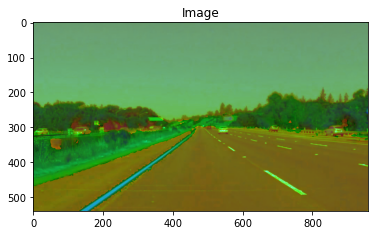

In [24]:
hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
plot_image(hls)

Gaussian Blur is applied with kernel size = 5, the size of the kernel is always recommended to be in odd number like 7,9,11 etc.

Canny edge detection is applied after this in order to detect the edges with higher weights of pixel in order to locate the lane lines.

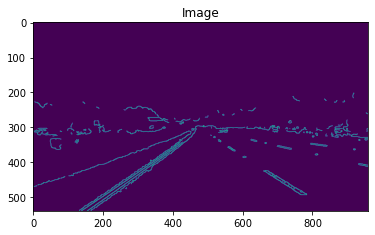

In [28]:
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_hls = cv2.GaussianBlur(hls,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_hls, low_threshold, high_threshold)
plot_image(edges)

# Region of interest
Considering the camera mounted position as a constant position lets focus on the lane area by marking the vertices to draw a polygon shape of the straight visible lane as below to identify the region of interest of the lane.

In [29]:
"""
Get the vertices

Considering the camera mounted constant position, 
the vertices are derived to locate the drivable lane 
"""
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

"""
Applies an image mask.

Only keeps the region of the image defined by the polygon
formed from `vertices`. The rest of the image is set to black.
`vertices` should be a numpy array of integer points.
"""
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   

    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

In [30]:
masked_img = region_of_interest(edges, get_vertices(edges))

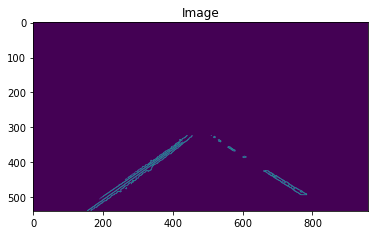

In [31]:
plot_image(masked_img)

# Hough transform
This technique is used in image processing to find the unique shapes in the image like straight lines, circles etc. In this case, the hough transform is applied to the ROI obtained from previous step to find the straight lane lines that are drawn on the road.

In [32]:
"""
`img` should be the output of a Canny transform.
 Returns an image with hough lines drawn.
"""
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = slope_lines(line_img,lines)
    return line_img

def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane.
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.

    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [33]:
houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
#Draw lines on edges

In [34]:
houghed_lines.shape

(540, 960, 3)

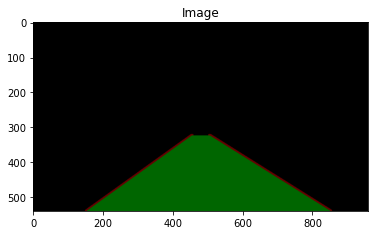

In [35]:
plot_image(houghed_lines)

In [44]:
def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ,dtype=cv2.CV_8U)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges

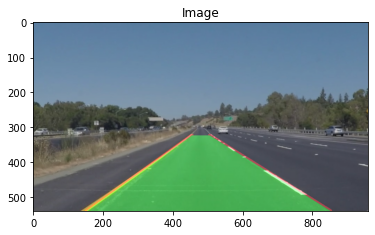

In [45]:
lines_edges = cv2.addWeighted(image, .8, houghed_lines, 1., 0.)
plot_image(lines_edges)

In [46]:
output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)

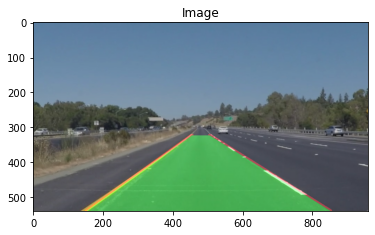

In [47]:
plot_image(output)

# Pipeline

In [48]:
def lane_finding_pipeline(image):
    
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    #Gaussian Smoothing
    blur_hls = cv2.GaussianBlur(hls,(5, 5),0)
    #Canny Edge Detection
    low_threshold = 180
    high_threshold = 240
    canny_img = cv2.Canny(blur_hls, low_threshold, high_threshold)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return output

In [60]:
import cv2
from moviepy.editor import VideoFileClip

def canny_webcam():
    "Live capture frames from webcam and show the canny edge image of the captured frames."

    cap = cv2.VideoCapture('results/test_videos/solidYellowLeft.mp4')
    frame_width = int(cap.get(3)) 
    frame_height = int(cap.get(4)) 
   
    size = (frame_width, frame_height) 
    
    result = cv2.VideoWriter('straight_lane.avi',  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         20, size)
    

    
    while (cap.isOpened()):
        ret, frame = cap.read()  # ret gets a boolean value. True if reading is successful (I think). frame is an
        if ret == True:
            # uint8 numpy.ndarray
            edge = lane_finding_pipeline(frame)
            result.write(edge) 
            cv2.imshow('Canny Edge', edge)

            if cv2.waitKey(20) & 0xFF == ord('q'):  # Introduce 20 milisecond delay. press q to exit.
                break
        else:
            break
    # When everything done, release the capture
    cap.release()
    result.release() 
    cv2.destroyAllWindows()
canny_webcam()

In [53]:
if __name__ == '__main__':

    vid_output = 'straightLane.mp4'
    # Location of the input video
    clip1 = VideoFileClip("results/test_videos/solidYellowLeft.mp4")
    # Create the clip
    vid_clip = clip1.fl_image(lane_finding_pipeline)
    vid_clip.write_videofile(vid_output, audio=False)

Moviepy - Building video straightLane.mp4.
Moviepy - Writing video straightLane.mp4



Moviepy - Done !
Moviepy - video ready straightLane.mp4
